# Modèle de la production éolienne Suisse

Ce modèle utilise :
- les installations éoliennes suisses (données SFOE/OFEN) avec leurs coordonnées géographiques
- les facteurs de production éolienne par région NUTS2 (données dérivées de ERA5, voir https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.4bd77450)

Il permet de calculer la production éolienne Suisse totale et par région NUTS2.

In [1]:
import pandas as pd

wind_plants = pd.read_csv('./data/CH_ElectricityProductionPlant_final.csv', parse_dates=True)
wind_plants = wind_plants[wind_plants['SubCategory'] == 'Solar_CH']

In [12]:
from math import isnan
import numpy as np
from pyproj import Transformer
from scipy.spatial.distance import cdist
import xarray as xr

transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")  # MN95 -> WGS84
#plants_mapped = False
#unique_pos = []

def map_plants(wind_factor):
    global plants_mapped
    global unique_pos
    print('Map pos...')
    wd40 = wind_factor.reset_index()
    wd40[['longitude', 'latitude']].drop_duplicates()
    grid = wd40[['longitude', 'latitude']].drop_duplicates()#gpt nul wind_factor.index.get_level_values(['longitude', 'latitude']).unique()
    del wd40

    def trouver_position_proche(row):
        if isnan(row['_x']) or isnan(row['_y']):
            # return center of switzerland
            lon, lat = 8.231974, 46.798562
        else:
            # Convertir les coordonnées en degrés décimaux
            lat, lon = transformer.transform(row['_x'], row['_y'])
        positions_grid = grid
        centrale_position = np.array([lon, lat])
        distances = cdist([centrale_position], positions_grid)
        index_plus_proche = np.argmin(distances)
        pos = positions_grid.iloc[index_plus_proche]
        return pos['longitude'], pos['latitude']

    # Attribution des positions les plus proches aux centrales
    psl = wind_plants.apply(trouver_position_proche, axis=1)
    wind_plants['long'], wind_plants['lat'] = [p[0] for p in psl], [p[1] for p in psl]

    unique_pos = [(x, y) for x, y in zip(wind_plants['long'], wind_plants['lat'])]
    print(len(unique_pos), 'vs', len(wind_plants))
    unique_pos = list(dict.fromkeys(unique_pos))
    plants_mapped = True
    del grid

def do_month(f):
    print('Read:', f)
    ds2 = xr.open_dataset(f'./data/solar_2021/{f}')
    wind_factor = ds2.to_dataframe().dropna()
    del ds2

    if not plants_mapped:
        map_plants(wind_factor)
    print('upos is', unique_pos)

    print('create frame')
    dates = wind_factor.index.levels[2]
    # There is some missing data added as 1900-01-01, for example in April 2021, so we remove it
    base_len = len(dates)
    dates = dates.drop(dates[dates.year != 2021])
    nw_len = len(dates)
    if base_len != nw_len:
        print('WARNING: Invalid dates removed. Data will be incomplete.')
    wind_factor_reduced = pd.DataFrame(index=dates)
    print('reducing...')
    for pos in unique_pos:
        print('check', pos)
        data = wind_factor.loc[pos[0], pos[1]]
        dt2 = dates.intersection(data.index)
        wind_factor_reduced[str(pos)] = data.loc[dt2]
    #wind_factor_reduced

    start = wind_factor_reduced.index[0]
    end = wind_factor_reduced.index[-1]
    freq = 'D'
    print('step 1. Do from', start, 'to', end, 'with freq', freq)

    # Générer un DataFrame avec l'index des dates
    dates = pd.date_range(start=start, end=end, freq=freq)
    by_date = pd.DataFrame(index=dates)
    print('step 2')

    # Calculer la puissance cumulée pour chaque région
    regions = unique_pos
    szh = len(regions)
    i = 0
    for region in regions:
        # Filtrer les installations pour la région donnée
        #print('Region is ', region, ' ', i,'/',szh)
        df_region = wind_plants[(wind_plants['long'] == region[0]) & (wind_plants['lat'] == region[1])]
        if len(df_region) == 0:
            continue
        #print('ERROR df reg is ', df_region, ' for ', region)

        # Regrouper par date de début d'opération et calculer la somme de la puissance
        df_grouped = df_region.groupby('BeginningOfOperation')['TotalPower'].sum()
        df_grouped.index = pd.to_datetime(df_grouped.index)

        # Puissance installée au début de l'année
        base_value = df_grouped.loc[:start].sum()
        # Réindexer pour inclure toutes les dates entre d1 et d2
        df_grouped = df_grouped.reindex(dates, fill_value=0)
        df_grouped.loc[start] = base_value
        #print('Power in ', region,' is ', df_grouped.cumsum())

        # Ajouter la colonne de puissance cumulée de la région au DataFrame de sortie
        by_date[str(region)] = df_grouped.cumsum()
        i = i + 1
    by_date = by_date / 1000  # Convertir en MWc

    print('last capa', by_date.iloc[-1].sum())

    #hour by hour
    by_date_rs = by_date.resample('H').first().loc[start:end]
    by_date_rs = by_date_rs.interpolate(method='pad', limit_direction='forward')
    rd = wind_factor_reduced.loc[start:end]
    produced_year = rd.multiply(by_date_rs).sum(axis=1)
    produced_year = produced_year / 1000  # Convertir en GWh

    print('===> Total:', produced_year.sum())
    del by_date
    del by_date_rs
    del rd
    del wind_factor_reduced
    del wind_factor
    return produced_year

ERROR! Session/line number was not unique in database. History logging moved to new session 223


In [13]:
# reset cache
plants_mapped = False
unique_pos = []

In [14]:
from os import listdir

files = listdir('./data/solar_2021')
dfs = []
for f in files:
    #f = 'H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202106010000_E202106302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc'
    #f = 'H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202109010000_E202109302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc'
    #f = 'H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202110010000_E202110312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc'
    dfs.append(do_month(f))
print('Done')
#prods = pd.concat(dfs)

Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202101010000_E202101312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
Map pos...
167325 vs 167325
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0), (7.75, 46.5), (10.25, 46.75), 

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

check (9.75, 47.25)
check (6.75, 46.25)
check (9.5, 46.25)
check (10.25, 46.25)
check (9.75, 46.25)
check (8.25, 46.25)
step 1. Do from 2021-01-01 00:00:00 to 2021-01-31 23:00:00 with freq D
step 2


C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  by_date[str(region)] = df_grouped.cumsum()
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  by_date[str(region)] = df_grouped.cumsum()
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

last capa 2800.11217
===> Total: 118.45618185934529
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202102010000_E202102282300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0), (7.75,

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 2833.73508
===> Total: 197.51716804019352
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202103010000_E202103312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0), (7.75,

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 2885.8915399999996
===> Total: 326.86789101564545
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202104010000_E202104302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0)

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 2930.0518199999997
===> Total: 408.2387722437933
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202105010000_E202105312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0),

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 2971.7510099999995
===> Total: 352.9226208472006
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202106010000_E202106302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0),

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3016.8998399999996
===> Total: 379.7134582791863
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202107010000_E202107312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0),

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3059.9654099999993
===> Total: 341.18266782529565
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202108010000_E202108312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0)

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3097.48429
===> Total: 321.0048491239185
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202109010000_E202109302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0), (7.75, 

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3146.3827100000003
===> Total: 308.52574985340755
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202110010000_E202110312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0)

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3192.01215
===> Total: 266.21382059747714
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202111010000_E202111302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0), (7.75,

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3245.70952
===> Total: 156.83155876442302
Read: H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202112010000_E202112312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc
upos is [(9.5, 47.25), (8.25, 47.25), (7.0, 47.0), (8.25, 46.75), (8.5, 47.75), (8.25, 47.0), (7.75, 47.0), (7.5, 47.0), (7.75, 46.75), (9.25, 47.5), (8.25, 47.5), (8.0, 47.25), (7.5, 47.5), (8.75, 47.5), (8.5, 47.5), (6.75, 46.75), (8.0, 47.5), (9.5, 47.5), (7.25, 47.0), (8.5, 47.0), (8.75, 47.25), (8.75, 47.75), (9.5, 46.75), (7.75, 47.5), (7.5, 46.75), (6.25, 46.5), (9.0, 46.0), (8.5, 47.25), (8.75, 46.25), (7.0, 47.25), (9.25, 47.25), (7.5, 46.5), (9.0, 46.25), (8.0, 47.0), (6.0, 46.25), (9.0, 47.75), (8.75, 46.75), (9.0, 47.5), (6.75, 46.5), (9.75, 46.75), (9.0, 46.5), (9.0, 46.75), (6.25, 46.25), (7.25, 46.25), (7.25, 47.25), (9.5, 47.0), (7.5, 47.25), (9.0, 47.0), (9.75, 46.5), (10.0, 47.0), (7.25, 46.75), (9.25, 46.75), (6.5, 46.5), (7.75, 47.25), (9.0, 45.75), (9.0, 47.25), (9.25, 47.75), (9.25, 47.0), (7.75,

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wind_factor_reduced[str(pos)] = data.loc[dt2]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_23012\159271483.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

last capa 3294.0740899999996
===> Total: 132.66700181985783
Done


In [47]:
dfs

[2021-01-01 00:00:00    0.001541
 2021-01-01 01:00:00    0.001435
 2021-01-01 02:00:00    0.000967
 2021-01-01 03:00:00    0.000546
 2021-01-01 04:00:00    0.000329
                          ...   
 2021-01-31 19:00:00    0.000000
 2021-01-31 20:00:00    0.000000
 2021-01-31 21:00:00    0.000000
 2021-01-31 22:00:00    0.000000
 2021-01-31 23:00:00    0.000000
 Length: 744, dtype: float64,
 2021-02-01 00:00:00    0.015207
 2021-02-01 01:00:00    0.019695
 2021-02-01 02:00:00    0.023663
 2021-02-01 03:00:00    0.021580
 2021-02-01 04:00:00    0.020818
                          ...   
 2021-02-28 19:00:00    0.000000
 2021-02-28 20:00:00    0.000000
 2021-02-28 21:00:00    0.000000
 2021-02-28 22:00:00    0.000000
 2021-02-28 23:00:00    0.000000
 Length: 672, dtype: float64,
 2021-03-01 00:00:00    0.000478
 2021-03-01 01:00:00    0.000263
 2021-03-01 02:00:00    0.000238
 2021-03-01 03:00:00    0.000210
 2021-03-01 04:00:00    0.000171
                          ...   
 2021-03-31 19:0

In [15]:
df = pd.concat(dfs)

In [16]:
df.resample('M').sum()

2021-01-31    118.456182
2021-02-28    197.517168
2021-03-31    326.867891
2021-04-30    408.238772
2021-05-31    352.922621
2021-06-30    379.713458
2021-07-31    341.182668
2021-08-31    321.004849
2021-09-30    308.525750
2021-10-31    266.213821
2021-11-30    156.831559
2021-12-31    132.667002
Freq: M, dtype: float64

In [17]:
iea_data = {
    '2021-01-31': 38.5,
    '2021-02-28': 112.3,
    '2021-03-31': 241.3,
    '2021-04-30': 356.9,
    '2021-05-31': 390.4,
    '2021-06-30': 437.3,
    '2021-07-31': 325.0,
    '2021-08-31': 407.1,
    '2021-09-30': 298.2,
    '2021-10-31': 177.6,
    '2021-11-30': 67.0,
    '2021-12-31': 40.2
}
iea_data = pd.DataFrame.from_dict(iea_data, orient='index', columns=['prod_iea'])

In [18]:
#######
# Data Pronovo.ch (https://www.energy-charts.info/)
#######
import pandas as pd
data = pd.read_csv("./data/energy-charts_Production_d'électricité_journalière__en_Suisse2021.csv", index_col='Jour')
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
data.drop(labels=['NaT'], inplace=True)
data = data.applymap(lambda x: float(x.replace(',', '.')))
pv = data['Photovoltaïque'].resample('M').sum()

iea_data.index = pv.index

In [19]:
own_monthly = df.resample('M').sum()
own_monthly.index = pv.index

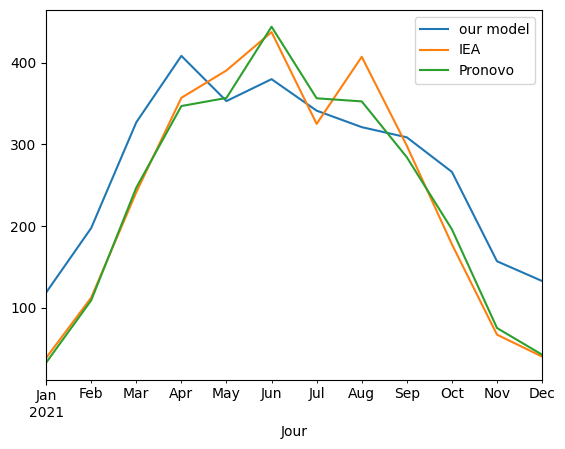

In [20]:
import matplotlib.pyplot as plt

ax = plt.gca()
own_monthly.plot(ax=ax)
iea_data.plot(ax=ax)
pv.plot(ax=ax)
plt.legend(['our model', 'IEA', 'Pronovo']);

In [21]:
df.sum()

3310.141740269744